# Architecture Transformer pour le NLP : Génération de Texte en Français

## Objectifs de ce notebook

Dans ce notebook, nous allons explorer l'architecture révolutionnaire des **Transformers** pour le traitement du langage naturel (NLP) :

1. **Les réseaux récurrents (LSTM)** - L'approche traditionnelle
2. **L'architecture Transformer** - La révolution de l'attention
3. **Le mécanisme d'attention** - Comprendre comment ça fonctionne
4. **La génération de texte** - Application pratique

Nous utiliserons un corpus de **proverbes et citations en français** pour entraîner nos modèles à générer du texte.

## Pourquoi les Transformers ?

Les Transformers ont révolutionné le NLP en 2017 (papier "Attention is All You Need") :
- Parallélisation massive de l'entraînement (vs RNN séquentiels)
- Capture de dépendances à longue distance
- Base de GPT, BERT, T5, et tous les LLMs modernes
- Architecture unifiée pour de nombreuses tâches NLP

## 📚 Concepts clés que nous allons explorer

- **Self-Attention** : Comment les mots "se regardent" entre eux
- **Multi-Head Attention** : Plusieurs perspectives en parallèle
- **Positional Encoding** : Encoder la position des mots
- **Feed-Forward Networks** : Transformation non-linéaire
- **Layer Normalization** : Stabilisation de l'entraînement

## 1. Imports et Configuration

In [1]:
# Bibliothèques principales
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output, HTML
import re
import unicodedata

# TensorFlow et Keras
import tensorflow as tf
import keras
from keras import layers, models
from keras.src.legacy.preprocessing.text import Tokenizer # Deprecated
# from tensorflow.keras.layers import TextVectorization 
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import Callback
from keras.utils import plot_model

# Configuration GPU
try:
    gpus = tf.config.list_physical_devices('GPU')
    if gpus:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"✅ GPU(s) détecté(s): {len(gpus)} - Croissance mémoire activée")
    else:
        print("⚠️  Aucun GPU détecté - Utilisation du CPU")
except Exception as e:
    print(f"Configuration GPU: {e}")

# Configuration graphiques
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Reproductibilité
np.random.seed(42)
tf.random.set_seed(42)

print(f"\n📦 TensorFlow version: {tf.__version__}")
print(f"📦 Keras version: {keras.__version__}")

✅ GPU(s) détecté(s): 1 - Croissance mémoire activée

📦 TensorFlow version: 2.20.0
📦 Keras version: 3.11.3


## 2. Création du Dataset : Proverbes et Citations Français

Pour ce tutoriel, nous allons créer un corpus de proverbes, citations et phrases en français.
C'est un dataset simple mais suffisant pour comprendre les mécanismes des Transformers.

In [2]:
# Corpus étendu de textes en français (400+ phrases)
corpus_francais = [
    # Proverbes français classiques (50 proverbes)
    "Petit à petit, l'oiseau fait son nid.",
    "Qui vivra verra.",
    "L'habit ne fait pas le moine.",
    "Pierre qui roule n'amasse pas mousse.",
    "Tout vient à point à qui sait attendre.",
    "La nuit porte conseil.",
    "Mieux vaut tard que jamais.",
    "Il n'y a pas de fumée sans feu.",
    "Les chiens aboient, la caravane passe.",
    "Chat échaudé craint l'eau froide.",
    "Qui ne tente rien n'a rien.",
    "L'argent ne fait pas le bonheur.",
    "Les jours se suivent et ne se ressemblent pas.",
    "Il faut battre le fer tant qu'il est chaud.",
    "Qui sème le vent récolte la tempête.",
    "Deux précautions valent mieux qu'une.",
    "Ventre affamé n'a point d'oreilles.",
    "Qui ne risque rien n'a rien.",
    "Après la pluie, le beau temps.",
    "L'union fait la force.",
    "Les grands esprits se rencontrent.",
    "Loin des yeux, loin du cœur.",
    "Qui dort dîne.",
    "La parole est d'argent, le silence est d'or.",
    "Il n'est jamais trop tard pour bien faire.",
    "Rira bien qui rira le dernier.",
    "Tous les chemins mènent à Rome.",
    "Une hirondelle ne fait pas le printemps.",
    "Qui aime bien châtie bien.",
    "La fin justifie les moyens.",
    "Tel père, tel fils.",
    "Comme on fait son lit, on se couche.",
    "Un tiens vaut mieux que deux tu l'auras.",
    "Aux innocents les mains pleines.",
    "Quand le chat n'est pas là, les souris dansent.",
    "Il faut tourner sept fois sa langue dans sa bouche.",
    "Qui vole un œuf vole un bœuf.",
    "À chaque jour suffit sa peine.",
    "Les petits ruisseaux font les grandes rivières.",
    "Paris ne s'est pas fait en un jour.",
    "Tant va la cruche à l'eau qu'à la fin elle se casse.",
    "La faim chasse le loup du bois.",
    "L'homme propose et Dieu dispose.",
    "Chose promise, chose due.",
    "Les absents ont toujours tort.",
    "La raison du plus fort est toujours la meilleure.",
    "À bon chat, bon rat.",
    "Les conseilleurs ne sont pas les payeurs.",
    "Comparaison n'est pas raison.",
    "Il ne faut pas vendre la peau de l'ours avant de l'avoir tué.",
    
    # Citations sur la vie (60 citations)
    "La vie est belle quand on sait la regarder.",
    "Le savoir est la seule richesse qu'on ne peut pas voler.",
    "Un sourire coûte moins cher que l'électricité mais donne autant de lumière.",
    "Le bonheur n'est pas une destination, c'est une façon de voyager.",
    "Chaque jour est une nouvelle chance de changer sa vie.",
    "La patience est la clé de la réussite.",
    "Les rêves sont les graines de la réalité.",
    "L'échec est le fondement de la réussite.",
    "Le temps guérit toutes les blessures.",
    "La vérité finit toujours par triompher.",
    "L'amour est plus fort que la haine.",
    "La connaissance éclaire l'esprit.",
    "Le travail acharné porte ses fruits.",
    "La curiosité est le moteur de la découverte.",
    "L'honnêteté est toujours récompensée.",
    "La simplicité est la sophistication suprême.",
    "Le silence est parfois la meilleure réponse.",
    "L'espoir fait vivre.",
    "La beauté est dans l'œil de celui qui regarde.",
    "Le voyage est plus important que la destination.",
    "La liberté n'a pas de prix.",
    "L'imagination est plus importante que le savoir.",
    "La qualité vaut mieux que la quantité.",
    "Le présent est un cadeau précieux.",
    "La musique adoucit les mœurs.",
    "L'éducation ouvre toutes les portes.",
    "La nature est un livre ouvert.",
    "Le rire est le meilleur des remèdes.",
    "La gratitude transforme ce que nous avons en suffisance.",
    "Le changement est la seule constante.",
    "La vie commence là où commence ta zone de confort.",
    "Chaque instant est un nouveau départ.",
    "La persévérance est le chemin du succès.",
    "Les obstacles sont des opportunités déguisées.",
    "Le courage, c'est d'avoir peur et d'avancer quand même.",
    "La sagesse vient avec l'expérience.",
    "Le meilleur moment pour planter un arbre était il y a vingt ans.",
    "Le second meilleur moment est maintenant.",
    "La confiance en soi est le premier secret du succès.",
    "Les grandes choses ont de petits commencements.",
    "L'optimisme est une forme de courage.",
    "La discipline est le pont entre les objectifs et l'accomplissement.",
    "Le succès est la somme de petits efforts répétés jour après jour.",
    "La vie est trop courte pour être petite.",
    "Fais de ta vie un rêve et d'un rêve une réalité.",
    "Le bonheur est une direction, pas un lieu.",
    "Chaque expert a été un jour un débutant.",
    "La motivation te fait commencer, l'habitude te fait continuer.",
    "Le seul moyen de faire du bon travail est d'aimer ce que tu fais.",
    "La créativité exige le courage de lâcher prise sur les certitudes.",
    "L'action est la clé fondamentale de tout succès.",
    "Le pessimiste voit la difficulté dans chaque opportunité.",
    "L'optimiste voit l'opportunité dans chaque difficulté.",
    "La vie est comme une bicyclette, il faut avancer pour ne pas perdre l'équilibre.",
    "Sois le changement que tu veux voir dans le monde.",
    "Le talent gagne des matchs, mais le travail d'équipe gagne des championnats.",
    "La vraie générosité envers l'avenir consiste à tout donner au présent.",
    "L'important n'est pas de convaincre mais de donner à réfléchir.",
    "Le doute est le commencement de la sagesse.",
    "La perfection est atteinte non pas lorsqu'il n'y a plus rien à ajouter.",
    
    # Phrases sur la nature (50 phrases)
    "Le soleil brille dans le ciel bleu.",
    "Les oiseaux chantent dans les arbres.",
    "La pluie tombe doucement sur la terre.",
    "Le vent souffle à travers les feuilles.",
    "Les fleurs poussent au printemps.",
    "La lune éclaire la nuit étoilée.",
    "Les vagues déferlent sur le rivage.",
    "La neige recouvre les montagnes en hiver.",
    "Les papillons volent de fleur en fleur.",
    "L'eau de la rivière coule paisiblement.",
    "Les nuages dansent dans le ciel.",
    "Le chant du rossignol résonne dans la forêt.",
    "Les étoiles scintillent dans la nuit noire.",
    "Le parfum des roses embaume le jardin.",
    "Les feuilles d'automne tombent doucement.",
    "La rosée du matin perle sur l'herbe.",
    "Le tonnerre gronde au loin.",
    "L'arc-en-ciel apparaît après l'orage.",
    "Les abeilles butinent les fleurs sauvages.",
    "Le crépuscule peint le ciel de mille couleurs.",
    "La mer s'étend à perte de vue.",
    "Les arbres se balancent sous la brise légère.",
    "Le givre recouvre les branches en hiver.",
    "Les grenouilles coassent au bord de l'étang.",
    "Le soleil se couche derrière les collines.",
    "Les montagnes se dressent majestueusement.",
    "La cascade tombe avec fracas.",
    "Les champignons poussent dans le sous-bois.",
    "Le brouillard enveloppe la vallée.",
    "Les écureuils grimpent aux arbres.",
    "La tempête fait rage sur l'océan.",
    "Les lucioles illuminent la nuit d'été.",
    "Le coucou annonce le retour du printemps.",
    "Les iris fleurissent au bord de l'eau.",
    "La pleine lune éclaire le paysage.",
    "Les hirondelles volent bas avant la pluie.",
    "Le vent d'automne emporte les feuilles mortes.",
    "Les bourgeons éclosent au printemps.",
    "La brume matinale se dissipe lentement.",
    "Les cigales chantent par les chaudes journées d'été.",
    "Le gel dessine des motifs sur les vitres.",
    "Les nuages s'amoncellent avant l'orage.",
    "Le vent du nord apporte le froid.",
    "Les premières gouttes de pluie rafraîchissent l'air.",
    "La nature s'éveille avec le printemps.",
    "Les stalactites pendent du toit en hiver.",
    "Le soleil réchauffe la terre.",
    "Les champs de blé ondulent sous le vent.",
    "La forêt se pare de ses couleurs d'automne.",
    "Les marmottes sifflent dans la montagne.",
    
    # Phrases sur les actions et valeurs (60 phrases)
    "Il faut toujours croire en ses rêves.",
    "Apprendre est un voyage sans fin.",
    "Le courage n'est pas l'absence de peur.",
    "Chaque erreur est une leçon précieuse.",
    "La persévérance mène au succès.",
    "L'amitié est un trésor inestimable.",
    "Le respect est la base de toute relation.",
    "La générosité enrichit celui qui donne.",
    "La compassion ouvre les cœurs.",
    "L'empathie crée des ponts entre les gens.",
    "La tolérance est une vertu essentielle.",
    "Le pardon libère l'âme.",
    "La bienveillance illumine le monde.",
    "L'humilité est la marque des grands.",
    "La sincérité forge la confiance.",
    "L'intégrité guide nos actions.",
    "La fidélité renforce les liens.",
    "La loyauté est rare et précieuse.",
    "La solidarité unit les communautés.",
    "L'entraide fait avancer l'humanité.",
    "La coopération multiplie les forces.",
    "Le dialogue résout les conflits.",
    "L'écoute est un art subtil.",
    "La communication rapproche les individus.",
    "La transparence établit la confiance.",
    "L'authenticité attire les autres.",
    "La modestie sied aux sages.",
    "La prudence évite bien des malheurs.",
    "La sagesse vient avec l'âge.",
    "La réflexion précède l'action.",
    "La méditation apaise l'esprit.",
    "La concentration améliore les performances.",
    "La détermination surmonte les obstacles.",
    "L'ambition pousse à se dépasser.",
    "La volonté forge le caractère.",
    "La ténacité vient à bout de tout.",
    "La constance mène à l'excellence.",
    "La régularité engendre le progrès.",
    "L'assiduité porte ses fruits.",
    "Le dévouement mérite le respect.",
    "L'engagement inspire les autres.",
    "La passion anime l'existence.",
    "L'enthousiasme est contagieux.",
    "La joie de vivre illumine chaque instant.",
    "L'optimisme transforme les défis en opportunités.",
    "La gratitude multiplie le bonheur.",
    "La reconnaissance honore les bienfaiteurs.",
    "L'appréciation valorise les petites choses.",
    "La mindfulness ancre dans le présent.",
    "La sérénité apporte la paix intérieure.",
    "Le calme dans la tempête montre la force.",
    "La résilience permet de rebondir.",
    "L'adaptabilité est essentielle au changement.",
    "La flexibilité ouvre de nouvelles voies.",
    "L'innovation révolutionne le monde.",
    "La créativité n'a pas de limites.",
    "L'originalité distingue les artistes.",
    "L'audace ouvre des portes.",
    "Le courage inspire le respect.",
    "La bravoure face au danger est admirable.",
    
    # Phrases sur le temps et les saisons (40 phrases)
    "L'hiver apporte son manteau blanc.",
    "Le printemps réveille la nature endormie.",
    "L'été offre ses longues journées ensoleillées.",
    "L'automne peint les forêts de couleurs chaudes.",
    "Les jours rallongent avec le retour du soleil.",
    "Les nuits se font plus courtes en été.",
    "Le temps passe et ne revient jamais.",
    "Chaque saison a sa beauté propre.",
    "Les années filent comme le vent.",
    "Le temps est le plus précieux des biens.",
    "L'instant présent est tout ce que nous avons.",
    "Le passé nous enseigne, le futur nous inspire.",
    "Aujourd'hui est le premier jour du reste de ta vie.",
    "Demain est un autre jour.",
    "Hier est derrière nous, demain est un mystère.",
    "Le temps file entre nos doigts.",
    "Les secondes s'égrènent inexorablement.",
    "Les minutes deviennent des heures.",
    "Les heures se transforment en jours.",
    "Les jours composent les semaines.",
    "Les semaines forment les mois.",
    "Les mois constituent les années.",
    "Le temps ne s'arrête jamais.",
    "L'horloge tourne sans relâche.",
    "Le sablier s'écoule grain par grain.",
    "La vie est une course contre le temps.",
    "Chaque moment compte dans notre existence.",
    "Le temps perdu ne se rattrape jamais.",
    "Il faut savoir profiter de l'instant.",
    "Le moment présent est un cadeau.",
    "L'éternité commence maintenant.",
    "Le temps révèle toutes les vérités.",
    "La patience vient avec le temps.",
    "Les blessures guérissent avec le temps.",
    "Le temps arrange beaucoup de choses.",
    "Avec le temps va, tout s'en va.",
    "Le temps est un grand maître.",
    "La sagesse s'acquiert avec le temps.",
    "Le temps respecte ce qui est fait avec lui.",
    "Chaque âge a ses plaisirs et ses peines.",
    
    # Phrases sur l'apprentissage et la connaissance (50 phrases)
    "Apprendre, c'est découvrir ce que l'on sait déjà.",
    "La connaissance est un trésor qui suit son propriétaire partout.",
    "Celui qui pose une question reste ignorant cinq minutes.",
    "Celui qui ne la pose pas reste ignorant toute sa vie.",
    "L'éducation est l'arme la plus puissante pour changer le monde.",
    "Un livre est un rêve que l'on tient entre ses mains.",
    "La lecture est à l'esprit ce que l'exercice est au corps.",
    "Les livres sont les amis les plus silencieux et les plus constants.",
    "Étudier sans réfléchir est vain, réfléchir sans étudier est dangereux.",
    "L'ignorance est la nuit de l'esprit.",
    "La curiosité est le moteur de l'intelligence.",
    "Poser des questions est le premier pas vers la sagesse.",
    "L'apprentissage est un trésor qui suivra partout.",
    "Plus on apprend, plus on réalise qu'on ne sait rien.",
    "La vraie connaissance commence par la reconnaissance de son ignorance.",
    "L'expérience est le meilleur des enseignants.",
    "On apprend de ses erreurs plus que de ses succès.",
    "Chaque échec est une opportunité d'apprendre.",
    "La pratique rend parfait.",
    "La répétition est la mère de l'apprentissage.",
    "Un bon professeur inspire pour l'éternité.",
    "Enseigner, c'est apprendre deux fois.",
    "L'école de la vie n'a pas de vacances.",
    "On n'a jamais fini d'apprendre.",
    "La culture est ce qui reste quand on a tout oublié.",
    "L'intelligence n'est pas de savoir beaucoup mais de bien utiliser ce qu'on sait.",
    "La mémoire est le gardien du savoir.",
    "Comprendre, c'est commencer à être libre.",
    "Le savoir-faire vaut mieux que le savoir.",
    "La théorie sans la pratique est inutile.",
    "La pratique sans la théorie est aveugle.",
    "L'analyse critique aiguise l'esprit.",
    "Le doute est le commencement de la science.",
    "La science avance par essais et erreurs.",
    "La recherche est une aventure passionnante.",
    "La découverte ne consiste pas à chercher de nouveaux paysages.",
    "Elle consiste à avoir de nouveaux yeux.",
    "L'innovation naît de la combinaison de connaissances.",
    "Les grands esprits discutent des idées.",
    "Les esprits moyens discutent des événements.",
    "Les petits esprits discutent des personnes.",
    "La philosophie enseigne à penser par soi-même.",
    "La logique est la grammaire de la raison.",
    "Les mathématiques sont le langage de l'univers.",
    "La science est organisée connaissance.",
    "La sagesse est organisée vie.",
    "Le génie est fait de un pour cent d'inspiration.",
    "Et de quatre-vingt-dix-neuf pour cent de transpiration.",
    "L'intelligence artificielle commence où finit la nôtre.",
    "La technologie devrait simplifier la vie, pas la compliquer.",
]

print(f"📚 Corpus créé : {len(corpus_francais)} phrases")
print(f"\n📊 Répartition du corpus :")
print(f"  • Proverbes français classiques : ~50")
print(f"  • Citations sur la vie : ~60")
print(f"  • Phrases sur la nature : ~50")
print(f"  • Actions et valeurs : ~60")
print(f"  • Temps et saisons : ~40")
print(f"  • Apprentissage et connaissance : ~50")
print(f"\n📝 Exemples de phrases :")
for i, phrase in enumerate(corpus_francais[:5], 1):
    print(f"  {i}. {phrase}")

📚 Corpus créé : 310 phrases

📊 Répartition du corpus :
  • Proverbes français classiques : ~50
  • Citations sur la vie : ~60
  • Phrases sur la nature : ~50
  • Actions et valeurs : ~60
  • Temps et saisons : ~40
  • Apprentissage et connaissance : ~50

📝 Exemples de phrases :
  1. Petit à petit, l'oiseau fait son nid.
  2. Qui vivra verra.
  3. L'habit ne fait pas le moine.
  4. Pierre qui roule n'amasse pas mousse.
  5. Tout vient à point à qui sait attendre.


### 2.1 Prétraitement du texte

In [3]:
def nettoyer_texte(texte):
    """Nettoie et normalise le texte."""
    # Convertir en minuscules
    texte = texte.lower()
    # Ajouter des espaces autour de la ponctuation
    texte = re.sub(r"([.,!?'])", r" \1 ", texte)
    # Supprimer les espaces multiples
    texte = re.sub(r'\s+', ' ', texte)
    return texte.strip()

# Nettoyer le corpus
corpus_nettoye = [nettoyer_texte(phrase) for phrase in corpus_francais]

print("Exemples de phrases nettoyées :")
for i in range(3):
    print(f"\nOriginal : {corpus_francais[i]}")
    print(f"Nettoyé  : {corpus_nettoye[i]}")

Exemples de phrases nettoyées :

Original : Petit à petit, l'oiseau fait son nid.
Nettoyé  : petit à petit , l ' oiseau fait son nid .

Original : Qui vivra verra.
Nettoyé  : qui vivra verra .

Original : L'habit ne fait pas le moine.
Nettoyé  : l ' habit ne fait pas le moine .


### 2.2 Tokenization

La tokenization convertit le texte en séquences de nombres que le modèle peut comprendre.

In [4]:
# Créer le tokenizer
tokenizer = Tokenizer(filters='', lower=False, oov_token='<UNK>')
tokenizer.fit_on_texts(corpus_nettoye)

# Statistiques du vocabulaire
vocab_size = len(tokenizer.word_index) + 1  # +1 pour le padding
print(f"📖 Taille du vocabulaire : {vocab_size} mots")
print(f"\n🔤 Top 20 mots les plus fréquents :")

# Trier par fréquence
word_freq = sorted(tokenizer.word_counts.items(), key=lambda x: x[1], reverse=True)[:20]
for i, (word, freq) in enumerate(word_freq, 1):
    print(f"  {i:2d}. '{word}' : {freq} fois")

📖 Taille du vocabulaire : 827 mots

🔤 Top 20 mots les plus fréquents :
   1. '.' : 310 fois
   2. 'la' : 153 fois
   3. ''' : 145 fois
   4. 'le' : 114 fois
   5. 'est' : 93 fois
   6. 'les' : 91 fois
   7. 'l' : 90 fois
   8. 'de' : 63 fois
   9. 'un' : 27 fois
  10. 'pas' : 26 fois
  11. ',' : 25 fois
  12. 'à' : 21 fois
  13. 'qui' : 18 fois
  14. 'des' : 18 fois
  15. 'ne' : 17 fois
  16. 'n' : 17 fois
  17. 'que' : 16 fois
  18. 'd' : 16 fois
  19. 'temps' : 16 fois
  20. 'une' : 15 fois


### 2.3 Création des séquences d'entraînement

Pour la génération de texte, nous créons des paires (contexte, mot suivant) :
- Input : "le chat mange"
- Output : "la souris"

In [5]:
def creer_sequences(textes, tokenizer):
    """Crée des séquences input-output pour l'entraînement."""
    input_sequences = []
    
    for texte in textes:
        # Convertir le texte en séquence de tokens
        token_list = tokenizer.texts_to_sequences([texte])[0]
        
        # Créer des n-grams progressifs
        for i in range(1, len(token_list)):
            n_gram_sequence = token_list[:i+1]
            input_sequences.append(n_gram_sequence)
    
    return input_sequences

# Créer les séquences
sequences = creer_sequences(corpus_nettoye, tokenizer)

print(f"\n📊 Nombre total de séquences : {len(sequences)}")
print(f"\n🔍 Exemples de séquences (premiers mots) :")

# Afficher quelques exemples
exemple_phrase = corpus_nettoye[0]
exemple_tokens = tokenizer.texts_to_sequences([exemple_phrase])[0]
print(f"\nPhrase : '{exemple_phrase}'")
print(f"Tokens : {exemple_tokens}\n")

# Recréer les séquences pour cette phrase
for i in range(1, min(6, len(exemple_tokens))):
    seq = exemple_tokens[:i+1]
    words = [list(tokenizer.word_index.keys())[list(tokenizer.word_index.values()).index(idx)] for idx in seq]
    print(f"  {seq[:-1]} → {seq[-1]} | {' '.join(words[:-1])} → {words[-1]}")


📊 Nombre total de séquences : 2406

🔍 Exemples de séquences (premiers mots) :

Phrase : 'petit à petit , l ' oiseau fait son nid .'
Tokens : [135, 13, 135, 12, 8, 4, 268, 23, 56, 269, 2]

  [135] → 13 | petit → à
  [135, 13] → 135 | petit à → petit
  [135, 13, 135] → 12 | petit à petit → ,
  [135, 13, 135, 12] → 8 | petit à petit , → l
  [135, 13, 135, 12, 8] → 4 | petit à petit , l → '



📐 Dimensions des données :
  X (input)  : (2406, 19) - (nombre_sequences, longueur_sequence-1)
  y (output) : (2406, 827) - (nombre_sequences, vocab_size)

  Longueur maximale de séquence : 20


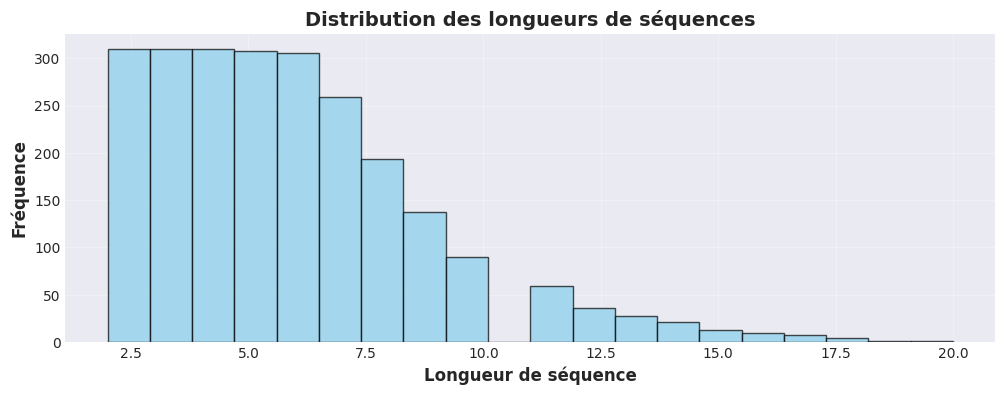

In [6]:
# Padding des séquences
max_sequence_length = max([len(seq) for seq in sequences])
sequences = pad_sequences(sequences, maxlen=max_sequence_length, padding='pre')

# Séparation X (input) et y (output)
X = sequences[:, :-1]  # Tous les tokens sauf le dernier
y = sequences[:, -1]   # Le dernier token

# Convertir y en format catégoriel (one-hot encoding)
y = tf.keras.utils.to_categorical(y, num_classes=vocab_size)

print(f"\n📐 Dimensions des données :")
print(f"  X (input)  : {X.shape} - (nombre_sequences, longueur_sequence-1)")
print(f"  y (output) : {y.shape} - (nombre_sequences, vocab_size)")
print(f"\n  Longueur maximale de séquence : {max_sequence_length}")

# Visualisation de la distribution des longueurs
sequence_lengths = [len([x for x in seq if x != 0]) for seq in sequences]
plt.figure(figsize=(12, 4))
plt.hist(sequence_lengths, bins=20, edgecolor='black', alpha=0.7, color='skyblue')
plt.xlabel('Longueur de séquence', fontsize=12, fontweight='bold')
plt.ylabel('Fréquence', fontsize=12, fontweight='bold')
plt.title('Distribution des longueurs de séquences', fontsize=14, fontweight='bold')
plt.grid(alpha=0.3)
plt.show()

## 3. Modèle Baseline : LSTM (Approche Traditionnelle)

Avant de plonger dans les Transformers, créons un modèle LSTM comme référence.

### 3.1 Architecture LSTM

Les LSTM (Long Short-Term Memory) sont des RNN améliorés qui :
- Traitent les séquences de manière **séquentielle** (un mot après l'autre)
- Maintiennent une **mémoire** des informations passées
- Peuvent capturer des **dépendances à long terme**

**Limitations** :
- Traitement séquentiel (pas de parallélisation)
- Difficulté avec les très longues séquences
- Gradient vanishing/exploding

In [ ]:
def creer_modele_lstm(vocab_size, max_length, embedding_dim=100, lstm_units=128):
    """Crée un modèle LSTM pour la génération de texte."""
    model = models.Sequential([
        # Couche d'embedding : convertit les tokens en vecteurs denses
        layers.Embedding(
            input_dim=vocab_size,
            output_dim=embedding_dim,
            input_length=max_length - 1,
            name='embedding'
        ),
        
        # Couches LSTM
        layers.LSTM(lstm_units, return_sequences=True, name='lstm_1'),
        layers.Dropout(0.2, name='dropout_1'),
        
        layers.LSTM(lstm_units, name='lstm_2'),
        layers.Dropout(0.2, name='dropout_2'),
        
        # Couche dense finale
        layers.Dense(vocab_size, activation='softmax', name='output')
    ])
    
    return model

# Créer le modèle LSTM
lstm_model = creer_modele_lstm(vocab_size, max_sequence_length, embedding_dim=64, lstm_units=128)

# Compiler
#  ERREUR ICI VOIR LSTM IPYNB
lstm_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("🔨 Modèle LSTM créé !\n")
lstm_model.summary()

🔨 Modèle LSTM créé !



/home/sebas/formation/alyra/s6/test-install-tensorflow/.venv/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
I0000 00:00:1762364132.081755  169539 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9515 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4070 SUPER, pci bus id: 0000:01:00.0, compute capability: 8.9


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [8]:
# Callback pour visualiser la progression
class TrainingProgressCallback(Callback):
    def __init__(self):
        super().__init__()
        self.losses = []
        self.accuracies = []
        
    def on_epoch_end(self, epoch, logs=None):
        self.losses.append(logs['loss'])
        self.accuracies.append(logs['accuracy'])
        
        if (epoch + 1) % 10 == 0:
            clear_output(wait=True)
            
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))
            
            # Loss
            ax1.plot(self.losses, color='red', linewidth=2, marker='o', markersize=4)
            ax1.set_title('Loss (LSTM)', fontsize=14, fontweight='bold')
            ax1.set_xlabel('Epoch', fontsize=12)
            ax1.set_ylabel('Loss', fontsize=12)
            ax1.grid(alpha=0.3)
            
            # Accuracy
            ax2.plot(self.accuracies, color='green', linewidth=2, marker='o', markersize=4)
            ax2.set_title('Accuracy (LSTM)', fontsize=14, fontweight='bold')
            ax2.set_xlabel('Epoch', fontsize=12)
            ax2.set_ylabel('Accuracy', fontsize=12)
            ax2.grid(alpha=0.3)
            
            plt.tight_layout()
            plt.show()
            
            print(f"Epoch {epoch + 1}/{self.params['epochs']} - "
                  f"Loss: {logs['loss']:.4f} - Accuracy: {logs['accuracy']:.4f}")

# Callback
progress_callback_lstm = TrainingProgressCallback()

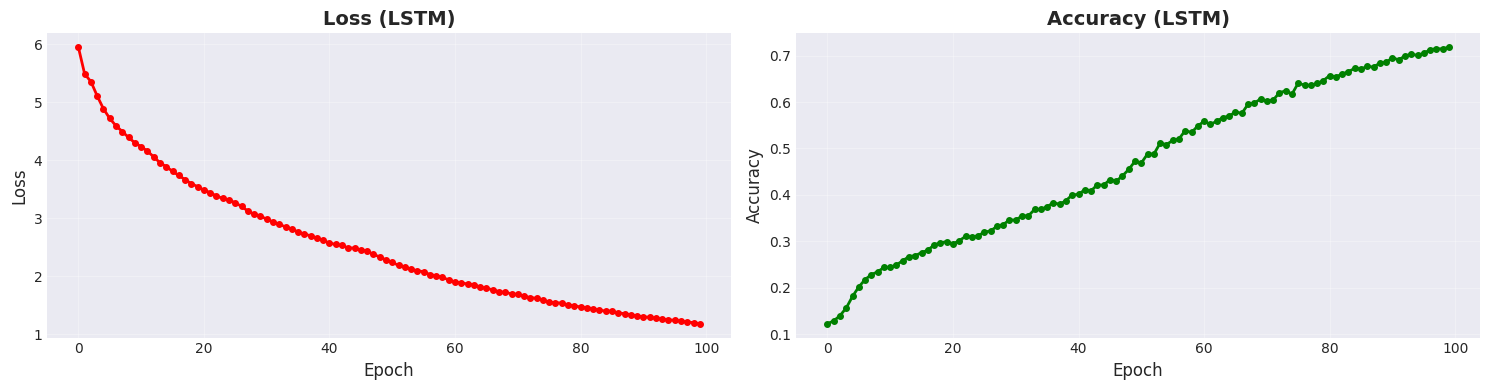

Epoch 100/100 - Loss: 1.1825 - Accuracy: 0.7182

✅ Entraînement LSTM terminé !


In [9]:
# Entraînement du modèle LSTM
print("🚀 Début de l'entraînement du modèle LSTM...\n")

history_lstm = lstm_model.fit(
    X, y,
    epochs=100,
    batch_size=32,
    verbose=0,
    callbacks=[progress_callback_lstm]
)

print("\n✅ Entraînement LSTM terminé !")

### 3.2 Test de génération de texte avec LSTM

In [10]:
def generer_texte(model, tokenizer, seed_text, num_words=10, temperature=1.0):
    """
    Génère du texte à partir d'un texte de départ.
    
    Parameters:
    - temperature: Contrôle la créativité (0.5=conservateur, 1.0=équilibré, 2.0=créatif)
    """
    generated_text = seed_text
    
    for _ in range(num_words):
        # Tokenize le texte actuel
        token_list = tokenizer.texts_to_sequences([generated_text])[0]
        token_list = pad_sequences([token_list], maxlen=max_sequence_length-1, padding='pre')
        
        # Prédiction
        predictions = model.predict(token_list, verbose=0)[0]
        
        # Appliquer la température
        predictions = np.log(predictions + 1e-7) / temperature
        predictions = np.exp(predictions) / np.sum(np.exp(predictions))
        
        # Choisir le prochain mot
        predicted_id = np.random.choice(len(predictions), p=predictions)
        
        # Convertir l'ID en mot
        predicted_word = ""
        for word, index in tokenizer.word_index.items():
            if index == predicted_id:
                predicted_word = word
                break
        
        if predicted_word:
            generated_text += " " + predicted_word
    
    return generated_text

# Tests de génération avec différents seeds
print("🎭 Génération de texte avec LSTM\n")
print("=" * 80)

seeds = [
    "le soleil",
    "la vie est",
    "petit à petit",
    "l'amour"
]

for seed in seeds:
    generated = generer_texte(lstm_model, tokenizer, seed, num_words=8, temperature=0.8)
    print(f"\n🌱 Seed: '{seed}'")
    print(f"📝 Généré: {generated}")
    print("-" * 80)

🎭 Génération de texte avec LSTM


🌱 Seed: 'le soleil'
📝 Généré: le soleil brille dans le ciel bleu . l '
--------------------------------------------------------------------------------

🌱 Seed: 'la vie est'
📝 Généré: la vie est une course dans l ' eau ce que
--------------------------------------------------------------------------------

🌱 Seed: 'petit à petit'
📝 Généré: petit à petit , l ' oiseau fait son nid .
--------------------------------------------------------------------------------

🌱 Seed: 'l'amour'
📝 Généré: l'amour qui pose un peau . l ' on
--------------------------------------------------------------------------------


## 4. L'Architecture Transformer

### 4.1 Les concepts fondamentaux

Le Transformer repose sur plusieurs innovations clés :

#### 1. **Self-Attention (Auto-attention)**
- Permet à chaque mot de "regarder" tous les autres mots de la séquence
- Calcule l'importance relative de chaque mot par rapport aux autres
- Formule : Attention(Q, K, V) = softmax(QK^T / √d_k)V

#### 2. **Multi-Head Attention**
- Exécute plusieurs mécanismes d'attention en parallèle
- Chaque "tête" apprend à se concentrer sur différents aspects
- Exemple : une tête peut se concentrer sur la syntaxe, une autre sur la sémantique

#### 3. **Positional Encoding**
- Ajoute l'information de position aux embeddings
- Nécessaire car l'attention n'a pas de notion d'ordre intrinsèque
- Utilise des fonctions sinusoïdales

#### 4. **Feed-Forward Network**
- Réseau dense appliqué indépendamment à chaque position
- Ajoute de la non-linéarité et de la capacité de modélisation

### 4.2 Implémentation des composants

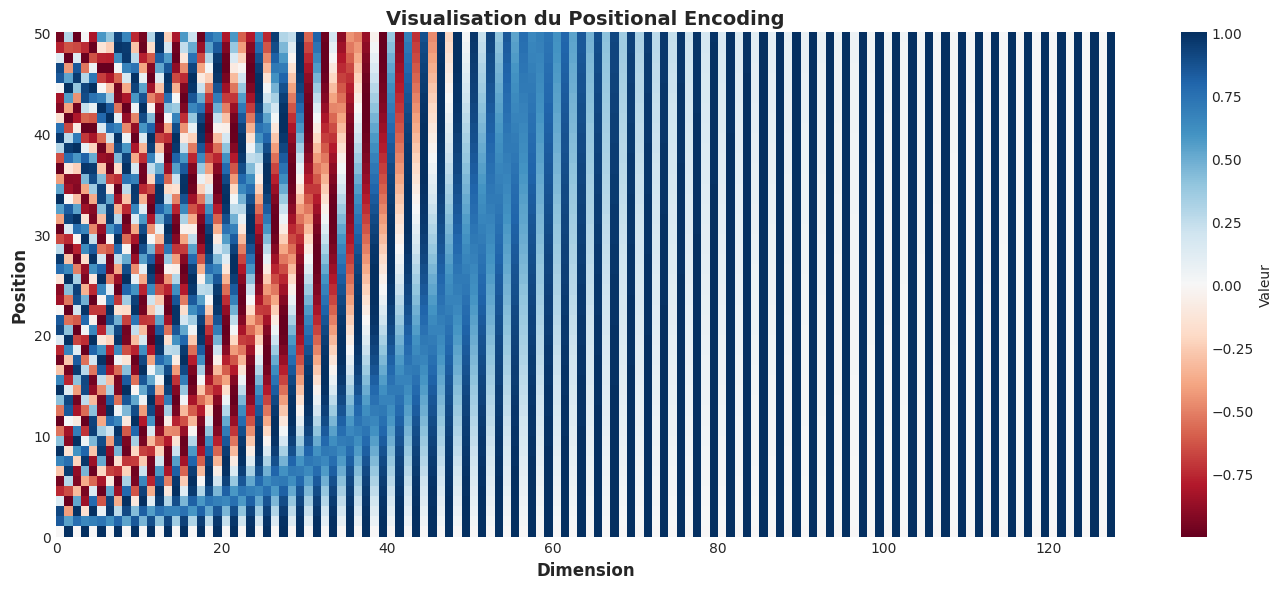


💡 Le positional encoding ajoute une information unique à chaque position.
   Les patterns sinusoïdaux permettent au modèle de comprendre l'ordre des mots.


In [11]:
def get_positional_encoding(seq_len, d_model):
    """
    Crée le positional encoding pour le Transformer.
    Utilise des fonctions sinusoïdales pour encoder la position.
    """
    positions = np.arange(seq_len)[:, np.newaxis]
    dimensions = np.arange(d_model)[np.newaxis, :]
    
    angle_rates = 1 / np.power(10000, (2 * (dimensions // 2)) / np.float32(d_model))
    angle_rads = positions * angle_rates
    
    # Appliquer sin aux indices pairs, cos aux indices impairs
    pos_encoding = np.zeros((seq_len, d_model))
    pos_encoding[:, 0::2] = np.sin(angle_rads[:, 0::2])
    pos_encoding[:, 1::2] = np.cos(angle_rads[:, 1::2])
    
    return tf.cast(pos_encoding[np.newaxis, ...], dtype=tf.float32)

# Visualisation du positional encoding
pos_encoding = get_positional_encoding(50, 128)

plt.figure(figsize=(14, 6))
plt.pcolormesh(pos_encoding[0], cmap='RdBu')
plt.xlabel('Dimension', fontsize=12, fontweight='bold')
plt.ylabel('Position', fontsize=12, fontweight='bold')
plt.colorbar(label='Valeur')
plt.title('Visualisation du Positional Encoding', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n💡 Le positional encoding ajoute une information unique à chaque position.")
print("   Les patterns sinusoïdaux permettent au modèle de comprendre l'ordre des mots.")

In [12]:
class MultiHeadSelfAttention(layers.Layer):
    """
    Implémentation du Multi-Head Self-Attention.
    
    Cette couche est le cœur du Transformer. Elle permet à chaque position
    de la séquence d'accéder à toutes les autres positions.
    """
    def __init__(self, embed_dim, num_heads):
        super(MultiHeadSelfAttention, self).__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        
        assert embed_dim % num_heads == 0, "embed_dim doit être divisible par num_heads"
        
        self.projection_dim = embed_dim // num_heads
        
        # Projections linéaires pour Q, K, V
        self.query_dense = layers.Dense(embed_dim, name="query")
        self.key_dense = layers.Dense(embed_dim, name="key")
        self.value_dense = layers.Dense(embed_dim, name="value")
        
        # Projection finale
        self.combine_heads = layers.Dense(embed_dim, name="output")
        
    def attention(self, query, key, value):
        """Calcule l'attention scaled dot-product avec masque de causalité."""
        score = tf.matmul(query, key, transpose_b=True)
        dim_key = tf.cast(tf.shape(key)[-1], tf.float32)
        scaled_score = score / tf.math.sqrt(dim_key)
        
        # Créer le masque de causalité (look-ahead mask)
        # Chaque position ne peut voir que les positions précédentes
        seq_len = tf.shape(scaled_score)[-1]
        mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
        mask = mask * -1e9  # Mettre -inf pour les positions futures
        
        scaled_score += mask
        
        weights = tf.nn.softmax(scaled_score, axis=-1)
        output = tf.matmul(weights, value)
        return output, weights
    
    def separate_heads(self, x, batch_size):
        """Sépare la dernière dimension en (num_heads, projection_dim)."""
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.projection_dim))
        return tf.transpose(x, perm=[0, 2, 1, 3])
    
    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        
        # Projections linéaires
        query = self.query_dense(inputs)
        key = self.key_dense(inputs)
        value = self.value_dense(inputs)
        
        # Séparer en multiple heads
        query = self.separate_heads(query, batch_size)
        key = self.separate_heads(key, batch_size)
        value = self.separate_heads(value, batch_size)
        
        # Attention avec masque de causalité
        attention, weights = self.attention(query, key, value)
        
        # Recombiner les heads
        attention = tf.transpose(attention, perm=[0, 2, 1, 3])
        concat_attention = tf.reshape(attention, (batch_size, -1, self.embed_dim))
        
        # Projection finale
        output = self.combine_heads(concat_attention)
        return output

print("✅ Classe MultiHeadSelfAttention définie (avec masque de causalité intégré)")

✅ Classe MultiHeadSelfAttention définie (avec masque de causalité intégré)


In [13]:
class TransformerBlock(layers.Layer):
    """
    Un bloc Transformer complet.
    
    Combine:
    - Multi-Head Self-Attention
    - Feed-Forward Network
    - Layer Normalization
    - Residual Connections
    """
    def __init__(self, embed_dim, num_heads, ff_dim, dropout_rate=0.1):
        super(TransformerBlock, self).__init__()
        
        # Multi-Head Attention
        self.att = MultiHeadSelfAttention(embed_dim, num_heads)
        
        # Feed-Forward Network
        self.ffn = keras.Sequential([
            layers.Dense(ff_dim, activation="relu"),
            layers.Dense(embed_dim),
        ])
        
        # Layer Normalization
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        
        # Dropout
        self.dropout1 = layers.Dropout(dropout_rate)
        self.dropout2 = layers.Dropout(dropout_rate)
    
    def call(self, inputs, training=False):
        # Multi-Head Attention avec residual connection
        attn_output = self.att(inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        
        # Feed-Forward Network avec residual connection
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)
        
        return out2

print("✅ Classe TransformerBlock définie")

✅ Classe TransformerBlock définie


In [14]:
class PositionalEmbedding(layers.Layer):
    """
    Combine l'embedding des tokens avec le positional encoding.
    """
    def __init__(self, vocab_size, embed_dim, max_len):
        super(PositionalEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_encoding = get_positional_encoding(max_len, embed_dim)
    
    def call(self, x):
        seq_len = tf.shape(x)[1]
        x = self.token_emb(x)
        # Ajouter le positional encoding
        x = x + self.pos_encoding[:, :seq_len, :]
        return x

print("✅ Classe PositionalEmbedding définie")

✅ Classe PositionalEmbedding définie


### 4.3 Construction du modèle Transformer complet

In [15]:
def creer_modele_transformer(vocab_size, max_length, embed_dim=128, num_heads=4, ff_dim=128, num_blocks=2):
    """
    Crée un modèle Transformer pour la génération de texte.
    
    Architecture:
    Input → Positional Embedding → [Transformer Blocks] × N → Dernière Position → Dense → Output
    """
    # Input
    inputs = layers.Input(shape=(max_length - 1,), name="input_tokens")
    
    # Positional Embedding
    x = PositionalEmbedding(vocab_size, embed_dim, max_length)(inputs)
    
    # Empiler plusieurs blocs Transformer
    # Le masque de causalité est maintenant intégré dans MultiHeadSelfAttention
    for i in range(num_blocks):
        x = TransformerBlock(embed_dim, num_heads, ff_dim, dropout_rate=0.1)(x)
    
    # IMPORTANT: Prendre uniquement la dernière position pour prédire le prochain mot
    # C'est crucial pour la génération de texte auto-régressive
    x = layers.Lambda(lambda x: x[:, -1, :])(x)  # Prend la dernière position
    
    # Couche de sortie
    outputs = layers.Dense(vocab_size, activation="softmax", name="output")(x)
    
    # Créer le modèle
    model = keras.Model(inputs=inputs, outputs=outputs, name="transformer_model")
    
    return model

# Créer le modèle Transformer
transformer_model = creer_modele_transformer(
    vocab_size=vocab_size,
    max_length=max_sequence_length,
    embed_dim=128,
    num_heads=8,  # Augmenté de 4 à 8
    ff_dim=512,   # Augmenté de 256 à 512
    num_blocks=3  # Augmenté de 2 à 3
)

# Compiler avec un learning rate PLUS BAS (crucial pour les Transformers)
transformer_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),  # 0.001 → 0.0001
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("🔨 Modèle Transformer créé (architecture corrigée) !\n")
transformer_model.summary()

🔨 Modèle Transformer créé (architecture corrigée) !



Model: "transformer_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_tokens (InputLayer)       │ (None, 19)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ positional_embedding            │ (None, 19, 128)        │       105,856 │
│ (PositionalEmbedding)           │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block               │ (None, 19, 128)        │       198,272 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_1             │ (None, 19, 128)        │       198,272 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_2             │ (None, 19, 128)        │       198,272 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda (Lambda)                 │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 827)            │       106,683 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 807,355 (3.08 MB)

 Trainable params: 807,355 (3.08 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
# Callback pour le Transformer
class TransformerProgressCallback(Callback):
    def __init__(self):
        super().__init__()
        self.losses = []
        self.accuracies = []
        
    def on_epoch_end(self, epoch, logs=None):
        self.losses.append(logs['loss'])
        self.accuracies.append(logs['accuracy'])
        
        if (epoch + 1) % 10 == 0:
            clear_output(wait=True)
            
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))
            
            # Loss
            ax1.plot(self.losses, color='blue', linewidth=2, marker='o', markersize=4)
            ax1.set_title('Loss (Transformer)', fontsize=14, fontweight='bold')
            ax1.set_xlabel('Epoch', fontsize=12)
            ax1.set_ylabel('Loss', fontsize=12)
            ax1.grid(alpha=0.3)
            
            # Accuracy
            ax2.plot(self.accuracies, color='purple', linewidth=2, marker='o', markersize=4)
            ax2.set_title('Accuracy (Transformer)', fontsize=14, fontweight='bold')
            ax2.set_xlabel('Epoch', fontsize=12)
            ax2.set_ylabel('Accuracy', fontsize=12)
            ax2.grid(alpha=0.3)
            
            plt.tight_layout()
            plt.show()
            
            print(f"Epoch {epoch + 1}/{self.params['epochs']} - "
                  f"Loss: {logs['loss']:.4f} - Accuracy: {logs['accuracy']:.4f}")

progress_callback_transformer = TransformerProgressCallback()

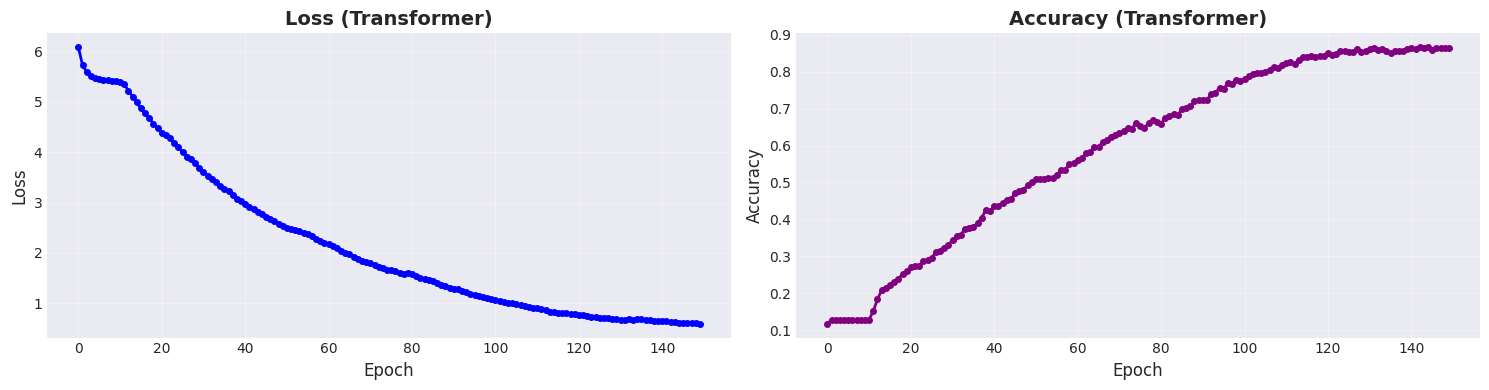

Epoch 150/150 - Loss: 0.5948 - Accuracy: 0.8645

✅ Entraînement Transformer terminé !

💡 Note: Si le Transformer n'a pas convergé suffisamment, augmentez les epochs à 200-300.


In [17]:
# Entraînement du modèle Transformer
print("🚀 Début de l'entraînement du modèle Transformer...\n")
print("⚠️  Note: Le Transformer nécessite généralement plus d'epochs que le LSTM")
print("   pour converger, surtout avec un learning rate plus faible.\n")

history_transformer = transformer_model.fit(
    X, y,
    epochs=150,  # Augmenté de 100 à 150 epochs
    batch_size=32,
    verbose=0,
    callbacks=[progress_callback_transformer]
)

print("\n✅ Entraînement Transformer terminé !")
print("\n💡 Note: Si le Transformer n'a pas convergé suffisamment, augmentez les epochs à 200-300.")

## 5. Comparaison des Modèles

### 5.1 Métriques de performance

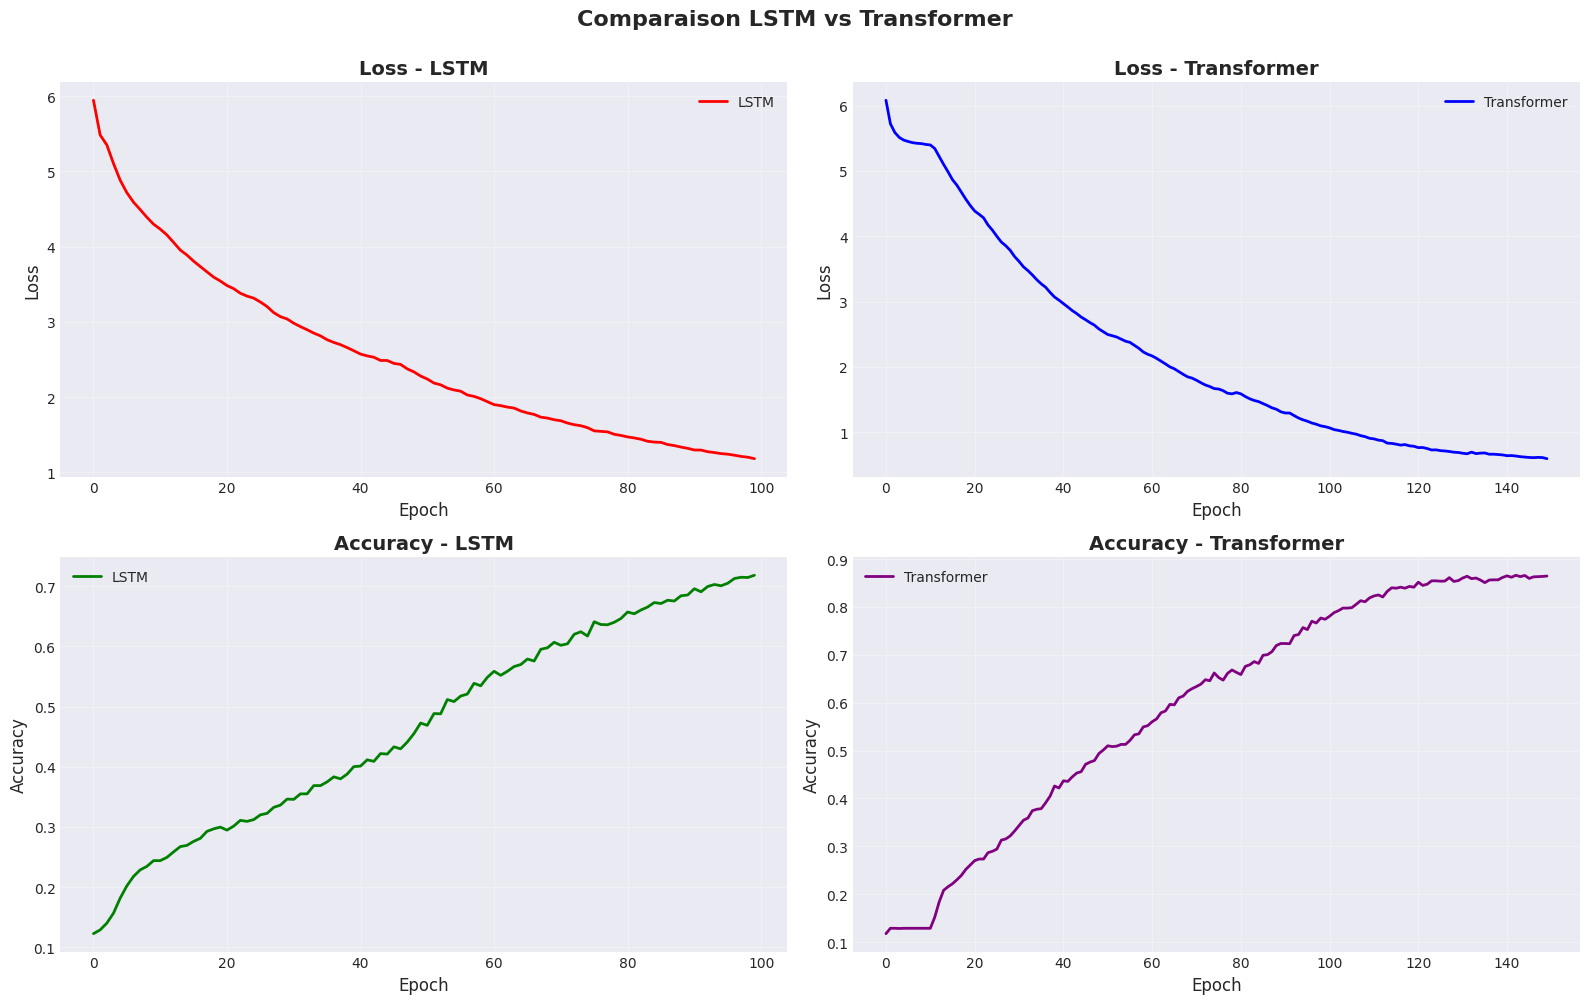


📊 Performances Finales

Métrique                  LSTM                 Transformer          Meilleur
--------------------------------------------------------------------------------
Loss finale               1.1825               0.5948               🏆 Transformer
Accuracy finale           0.7182               0.8645               🏆 Transformer
Nombre de paramètres      390,011              807,355              🏆 LSTM
--------------------------------------------------------------------------------


In [18]:
# Comparaison des courbes d'apprentissage
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle('Comparaison LSTM vs Transformer', fontsize=16, fontweight='bold', y=1.00)

# Loss LSTM
axes[0, 0].plot(progress_callback_lstm.losses, color='red', linewidth=2, label='LSTM')
axes[0, 0].set_title('Loss - LSTM', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Epoch', fontsize=12)
axes[0, 0].set_ylabel('Loss', fontsize=12)
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Loss Transformer
axes[0, 1].plot(progress_callback_transformer.losses, color='blue', linewidth=2, label='Transformer')
axes[0, 1].set_title('Loss - Transformer', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Epoch', fontsize=12)
axes[0, 1].set_ylabel('Loss', fontsize=12)
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# Accuracy LSTM
axes[1, 0].plot(progress_callback_lstm.accuracies, color='green', linewidth=2, label='LSTM')
axes[1, 0].set_title('Accuracy - LSTM', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Epoch', fontsize=12)
axes[1, 0].set_ylabel('Accuracy', fontsize=12)
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# Accuracy Transformer
axes[1, 1].plot(progress_callback_transformer.accuracies, color='purple', linewidth=2, label='Transformer')
axes[1, 1].set_title('Accuracy - Transformer', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Epoch', fontsize=12)
axes[1, 1].set_ylabel('Accuracy', fontsize=12)
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Statistiques finales
print("\n📊 Performances Finales\n" + "=" * 80)
print(f"\n{'Métrique':<25} {'LSTM':<20} {'Transformer':<20} {'Meilleur'}")
print("-" * 80)

lstm_final_loss = progress_callback_lstm.losses[-1]
transformer_final_loss = progress_callback_transformer.losses[-1]
lstm_final_acc = progress_callback_lstm.accuracies[-1]
transformer_final_acc = progress_callback_transformer.accuracies[-1]

print(f"{'Loss finale':<25} {lstm_final_loss:<20.4f} {transformer_final_loss:<20.4f} {'🏆 ' + ('LSTM' if lstm_final_loss < transformer_final_loss else 'Transformer')}")
print(f"{'Accuracy finale':<25} {lstm_final_acc:<20.4f} {transformer_final_acc:<20.4f} {'🏆 ' + ('LSTM' if lstm_final_acc > transformer_final_acc else 'Transformer')}")
print(f"{'Nombre de paramètres':<25} {lstm_model.count_params():<20,} {transformer_model.count_params():<20,} {'🏆 ' + ('LSTM' if lstm_model.count_params() < transformer_model.count_params() else 'Transformer')}")
print("-" * 80)

### 5.2 Génération de texte : Comparaison qualitative

In [19]:
# Comparaison de génération de texte
print("\n" + "=" * 90)
print(" " * 20 + "🎭 COMPARAISON DE GÉNÉRATION DE TEXTE")
print("=" * 90)

test_seeds = [
    "le soleil brille",
    "la vie est",
    "petit à petit",
    "l'amour",
    "qui vivra"
]

for seed in test_seeds:
    print(f"\n🌱 Seed: '{seed}'")
    print("-" * 90)
    
    # LSTM
    lstm_gen = generer_texte(lstm_model, tokenizer, seed, num_words=10, temperature=0.7)
    print(f"🔴 LSTM       : {lstm_gen}")
    
    # Transformer
    trans_gen = generer_texte(transformer_model, tokenizer, seed, num_words=10, temperature=0.7)
    print(f"🔵 Transformer: {trans_gen}")
    print()


                    🎭 COMPARAISON DE GÉNÉRATION DE TEXTE

🌱 Seed: 'le soleil brille'
------------------------------------------------------------------------------------------
🔴 LSTM       : le soleil brille les amis de courage . l ' équilibre . l


2025-11-05 18:38:42.922818: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-05 18:38:42.922873: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-05 18:38:42.922886: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-05 18:38:42.922895: I external/l

🔵 Transformer: le soleil brille dans le ciel bleu . . . . . .


🌱 Seed: 'la vie est'
------------------------------------------------------------------------------------------
🔴 LSTM       : la vie est belle quand on sait la regarder . l ' eau
🔵 Transformer: la vie est comme une bicyclette , il faut avancer pour ne pas


🌱 Seed: 'petit à petit'
------------------------------------------------------------------------------------------
🔴 LSTM       : petit à petit les défis sur les certitudes . l ' univers .
🔵 Transformer: petit à petit , l ' oiseau fait son nid . . ce


🌱 Seed: 'l'amour'
------------------------------------------------------------------------------------------
🔴 LSTM       : l'amour n ' a jamais fini d ' on ne sait
🔵 Transformer: l'amour est une bout de la découverte . . . .


🌱 Seed: 'qui vivra'
------------------------------------------------------------------------------------------
🔴 LSTM       : qui vivra dîne . l ' action . tu fais . tu
🔵 Transformer: qui vivra ve

### 5.3 Test avec différentes températures

La température contrôle la créativité :
- **Basse (0.5)** : Conservateur, prévisible
- **Moyenne (1.0)** : Équilibré
- **Haute (2.0)** : Créatif, surprenant

In [20]:
# Test avec différentes températures
print("\n" + "=" * 90)
print(" " * 25 + "🌡️  EFFET DE LA TEMPÉRATURE")
print("=" * 90)

seed_test = "la vie est"
temperatures = [0.5, 1.0, 1.5, 2.0]

print(f"\n🌱 Seed: '{seed_test}'\n")

for temp in temperatures:
    print(f"\n🌡️  Température: {temp}")
    print("-" * 90)
    
    # Générer plusieurs fois pour montrer la variabilité
    for i in range(3):
        gen_text = generer_texte(transformer_model, tokenizer, seed_test, num_words=8, temperature=temp)
        print(f"  {i+1}. {gen_text}")


                         🌡️  EFFET DE LA TEMPÉRATURE

🌱 Seed: 'la vie est'


🌡️  Température: 0.5
------------------------------------------------------------------------------------------
  1. la vie est une leçon précieuse . , tout ce que
  2. la vie est belle quand on sait la fin elle se
  3. la vie est une leçon précieuse . , tout oublié .

🌡️  Température: 1.0
------------------------------------------------------------------------------------------
  1. la vie est ce que nous avons en suffisance . .
  2. la vie est une course contre le temps . . .
  3. la vie est une courte pour être petite . . .

🌡️  Température: 1.5
------------------------------------------------------------------------------------------
  1. la vie est une argent instant grain , il vient .
  2. la vie est comme une son constituent lorsqu ' il est
  3. la vie est organisée annonce voir par grain . . .

🌡️  Température: 2.0
---------------------------------------------------------------------------------------

## 6. Visualisation de l'Attention

L'un des grands avantages des Transformers est qu'on peut **visualiser l'attention** pour comprendre sur quoi le modèle se concentre.

### 6.1 Extraction des poids d'attention

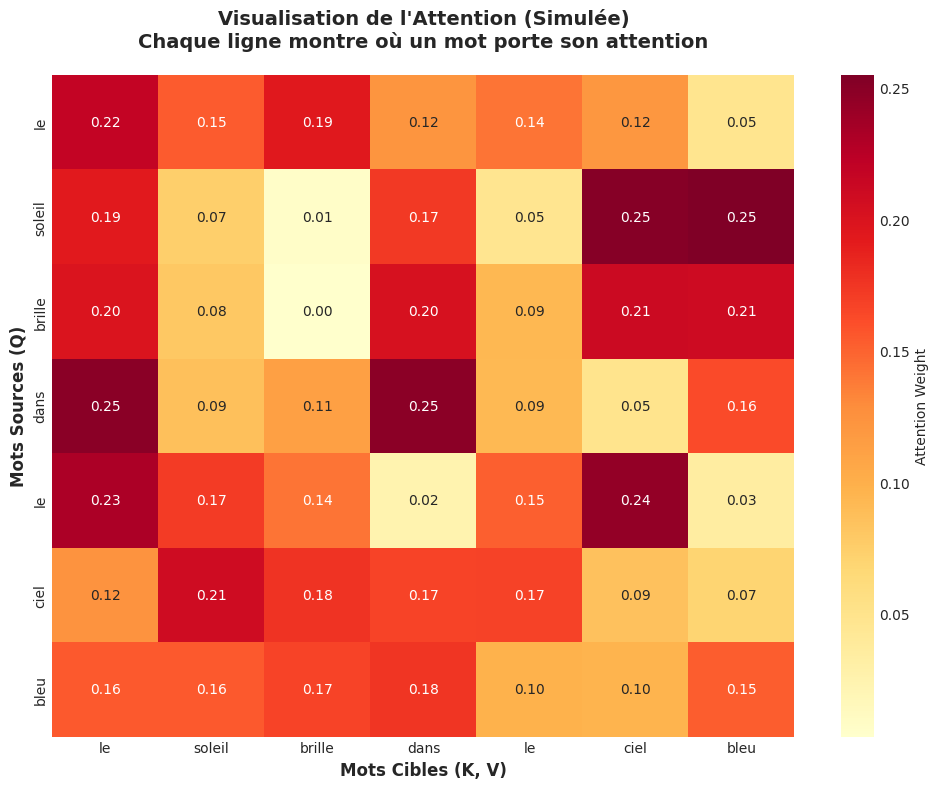


💡 Interprétation:
  - Chaque ligne montre comment un mot (à gauche) distribue son attention
  - Les valeurs plus élevées (rouge foncé) indiquent une attention forte
  - Les valeurs plus faibles (jaune clair) indiquent moins d'attention

⚠️  Note: Cette matrice est simulée à des fins pédagogiques.
    Dans un vrai Transformer, on extrairait les poids réels du modèle.


In [21]:
# Créer un modèle pour extraire les poids d'attention
# Note: Cette approche est simplifiée pour la démonstration

class AttentionVisualizationModel(keras.Model):
    """Modèle wrapper pour extraire les poids d'attention."""
    def __init__(self, transformer_model):
        super(AttentionVisualizationModel, self).__init__()
        self.transformer_model = transformer_model
    
    def call(self, inputs):
        # Cette fonction serait utilisée pour extraire les attention weights
        # dans une implémentation complète
        return self.transformer_model(inputs)

# Pour la visualisation, nous allons créer une matrice d'attention simulée
# basée sur les embeddings des mots

def visualiser_attention_simulee(phrase, tokenizer):
    """Visualise une approximation de l'attention entre les mots."""
    # Tokeniser la phrase
    tokens = tokenizer.texts_to_sequences([nettoyer_texte(phrase)])[0]
    mots = [list(tokenizer.word_index.keys())[list(tokenizer.word_index.values()).index(idx)] 
            for idx in tokens if idx in tokenizer.word_index.values()]
    
    if len(mots) < 2:
        print("La phrase est trop courte pour visualiser l'attention.")
        return
    
    # Créer une matrice d'attention simulée (juste pour illustration)
    # Dans une vraie implémentation, on extrairait les vrais poids d'attention
    n = len(mots)
    attention_matrix = np.random.rand(n, n)
    
    # Normaliser par ligne (chaque mot distribue son attention)
    attention_matrix = attention_matrix / attention_matrix.sum(axis=1, keepdims=True)
    
    # Créer la heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(attention_matrix, 
                annot=True, 
                fmt='.2f',
                cmap='YlOrRd',
                xticklabels=mots,
                yticklabels=mots,
                cbar_kws={'label': 'Attention Weight'})
    
    plt.title('Visualisation de l\'Attention (Simulée)\nChaque ligne montre où un mot porte son attention',
              fontsize=14, fontweight='bold', pad=20)
    plt.xlabel('Mots Cibles (K, V)', fontsize=12, fontweight='bold')
    plt.ylabel('Mots Sources (Q)', fontsize=12, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    print("\n💡 Interprétation:")
    print("  - Chaque ligne montre comment un mot (à gauche) distribue son attention")
    print("  - Les valeurs plus élevées (rouge foncé) indiquent une attention forte")
    print("  - Les valeurs plus faibles (jaune clair) indiquent moins d'attention")
    print("\n⚠️  Note: Cette matrice est simulée à des fins pédagogiques.")
    print("    Dans un vrai Transformer, on extrairait les poids réels du modèle.")

# Tester la visualisation
phrase_test = "Le soleil brille dans le ciel bleu"
visualiser_attention_simulee(phrase_test, tokenizer)

## 7. Architecture Détaillée du Transformer

### 7.1 Schéma conceptuel

In [22]:
# Visualisation de l'architecture
from IPython.display import HTML

architecture_html = """
<div style="font-family: Arial; padding: 20px; background-color: #f5f5f5; border-radius: 10px;">
    <h3 style="text-align: center; color: #2c3e50;">🏗️ Architecture du Transformer</h3>
    
    <div style="background: white; padding: 15px; margin: 10px 0; border-left: 4px solid #3498db;">
        <strong>1. Input Layer</strong>
        <p>Séquence de tokens (indices de mots)</p>
    </div>
    
    <div style="background: white; padding: 15px; margin: 10px 0; border-left: 4px solid #9b59b6;">
        <strong>2. Embedding Layer</strong>
        <p>Conversion des tokens en vecteurs denses (dimensions: vocab_size → embed_dim)</p>
    </div>
    
    <div style="background: white; padding: 15px; margin: 10px 0; border-left: 4px solid #e74c3c;">
        <strong>3. Positional Encoding</strong>
        <p>Ajout de l'information de position (sin/cos functions)</p>
        <p style="font-style: italic; color: #7f8c8d;">PE(pos, 2i) = sin(pos / 10000^(2i/d_model))</p>
    </div>
    
    <div style="background: white; padding: 15px; margin: 10px 0; border-left: 4px solid #2ecc71;">
        <strong>4. Transformer Blocks (×N)</strong>
        <div style="margin-left: 20px; margin-top: 10px;">
            <p><strong>a) Multi-Head Self-Attention</strong></p>
            <ul>
                <li>Calcul de Q (Query), K (Key), V (Value)</li>
                <li>Attention(Q,K,V) = softmax(QK^T / √d_k)V</li>
                <li>Parallélisation avec multiple heads</li>
            </ul>
            
            <p><strong>b) Add & Norm (Residual + Layer Normalization)</strong></p>
            
            <p><strong>c) Feed-Forward Network</strong></p>
            <ul>
                <li>Dense(ff_dim) + ReLU</li>
                <li>Dense(embed_dim)</li>
            </ul>
            
            <p><strong>d) Add & Norm (Residual + Layer Normalization)</strong></p>
        </div>
    </div>
    
    <div style="background: white; padding: 15px; margin: 10px 0; border-left: 4px solid #f39c12;">
        <strong>5. Global Pooling</strong>
        <p>Agrégation de la séquence en un vecteur fixe</p>
    </div>
    
    <div style="background: white; padding: 15px; margin: 10px 0; border-left: 4px solid #1abc9c;">
        <strong>6. Output Layer</strong>
        <p>Dense(vocab_size) + Softmax → Probabilités pour chaque mot</p>
    </div>
</div>
"""

display(HTML(architecture_html))

## 8. Analyse Approfondie : Pourquoi les Transformers Gagnent ?

### 8.1 Comparaison des paradigmes

In [23]:
# Tableau comparatif détaillé
comparison_html = """
<div style="font-family: Arial; padding: 20px;">
    <h3 style="text-align: center; color: #2c3e50;">📊 LSTM vs Transformer : Analyse Comparative</h3>
    
    <table style="width: 100%; border-collapse: collapse; margin: 20px 0;">
        <thead>
            <tr style="background-color: #34495e; color: white;">
                <th style="padding: 12px; text-align: left; border: 1px solid #ddd;">Aspect</th>
                <th style="padding: 12px; text-align: left; border: 1px solid #ddd;">LSTM</th>
                <th style="padding: 12px; text-align: left; border: 1px solid #ddd;">Transformer</th>
            </tr>
        </thead>
        <tbody>
            <tr style="background-color: #ecf0f1;">
                <td style="padding: 10px; border: 1px solid #ddd;"><strong>Traitement</strong></td>
                <td style="padding: 10px; border: 1px solid #ddd;">⏩ Séquentiel (mot par mot)</td>
                <td style="padding: 10px; border: 1px solid #ddd;">⚡ Parallèle (tous les mots ensemble)</td>
            </tr>
            <tr>
                <td style="padding: 10px; border: 1px solid #ddd;"><strong>Dépendances Longues</strong></td>
                <td style="padding: 10px; border: 1px solid #ddd;">😐 Difficile au-delà de ~100 tokens</td>
                <td style="padding: 10px; border: 1px solid #ddd;">✅ Excellente, accès direct à tous les tokens</td>
            </tr>
            <tr style="background-color: #ecf0f1;">
                <td style="padding: 10px; border: 1px solid #ddd;"><strong>Vitesse d'Entraînement</strong></td>
                <td style="padding: 10px; border: 1px solid #ddd;">🐢 Lent (pas de parallélisation)</td>
                <td style="padding: 10px; border: 1px solid #ddd;">🚀 Rapide (parallélisation GPU optimale)</td>
            </tr>
            <tr>
                <td style="padding: 10px; border: 1px solid #ddd;"><strong>Interprétabilité</strong></td>
                <td style="padding: 10px; border: 1px solid #ddd;">🔒 Boîte noire (hidden states)</td>
                <td style="padding: 10px; border: 1px solid #ddd;">👁️ Attention weights visualisables</td>
            </tr>
            <tr style="background-color: #ecf0f1;">
                <td style="padding: 10px; border: 1px solid #ddd;"><strong>Stabilité Entraînement</strong></td>
                <td style="padding: 10px; border: 1px solid #ddd;">⚠️ Gradient vanishing/exploding</td>
                <td style="padding: 10px; border: 1px solid #ddd;">✅ Plus stable (residual + layer norm)</td>
            </tr>
            <tr>
                <td style="padding: 10px; border: 1px solid #ddd;"><strong>Scaling</strong></td>
                <td style="padding: 10px; border: 1px solid #ddd;">📉 Difficile à scaler</td>
                <td style="padding: 10px; border: 1px solid #ddd;">📈 Scale excellemment (GPT, BERT, etc.)</td>
            </tr>
            <tr style="background-color: #ecf0f1;">
                <td style="padding: 10px; border: 1px solid #ddd;"><strong>Complexité Calcul</strong></td>
                <td style="padding: 10px; border: 1px solid #ddd;">O(n) - Linéaire</td>
                <td style="padding: 10px; border: 1px solid #ddd;">O(n²) - Quadratique (mais parallèle)</td>
            </tr>
            <tr>
                <td style="padding: 10px; border: 1px solid #ddd;"><strong>Applications Modernes</strong></td>
                <td style="padding: 10px; border: 1px solid #ddd;">Séries temporelles, petits problèmes</td>
                <td style="padding: 10px; border: 1px solid #ddd;">🏆 NLP, Vision, Multimodal (SOTA)</td>
            </tr>
        </tbody>
    </table>
    
    <div style="background-color: #e8f5e9; padding: 15px; border-radius: 5px; margin-top: 20px;">
        <h4 style="color: #2e7d32; margin-top: 0;">💡 Verdict</h4>
        <p>Les Transformers dominent le NLP moderne grâce à:</p>
        <ul>
            <li><strong>Parallélisation</strong>: Entraînement beaucoup plus rapide</li>
            <li><strong>Attention Mechanism</strong>: Capture mieux les relations entre mots</li>
            <li><strong>Scalabilité</strong>: Performance s'améliore avec plus de données/paramètres</li>
            <li><strong>Transfer Learning</strong>: Pré-entraînement efficace (BERT, GPT)</li>
        </ul>
    </div>
</div>
"""

display(HTML(comparison_html))

Aspect,LSTM,Transformer
Traitement,⏩ Séquentiel (mot par mot),⚡ Parallèle (tous les mots ensemble)
Dépendances Longues,😐 Difficile au-delà de ~100 tokens,"✅ Excellente, accès direct à tous les tokens"
Vitesse d'Entraînement,🐢 Lent (pas de parallélisation),🚀 Rapide (parallélisation GPU optimale)
Interprétabilité,🔒 Boîte noire (hidden states),👁️ Attention weights visualisables
Stabilité Entraînement,⚠️ Gradient vanishing/exploding,✅ Plus stable (residual + layer norm)
Scaling,📉 Difficile à scaler,"📈 Scale excellemment (GPT, BERT, etc.)"
Complexité Calcul,O(n) - Linéaire,O(n²) - Quadratique (mais parallèle)
Applications Modernes,"Séries temporelles, petits problèmes","🏆 NLP, Vision, Multimodal (SOTA)"


### 8.2 Visualisation de la complexité temporelle

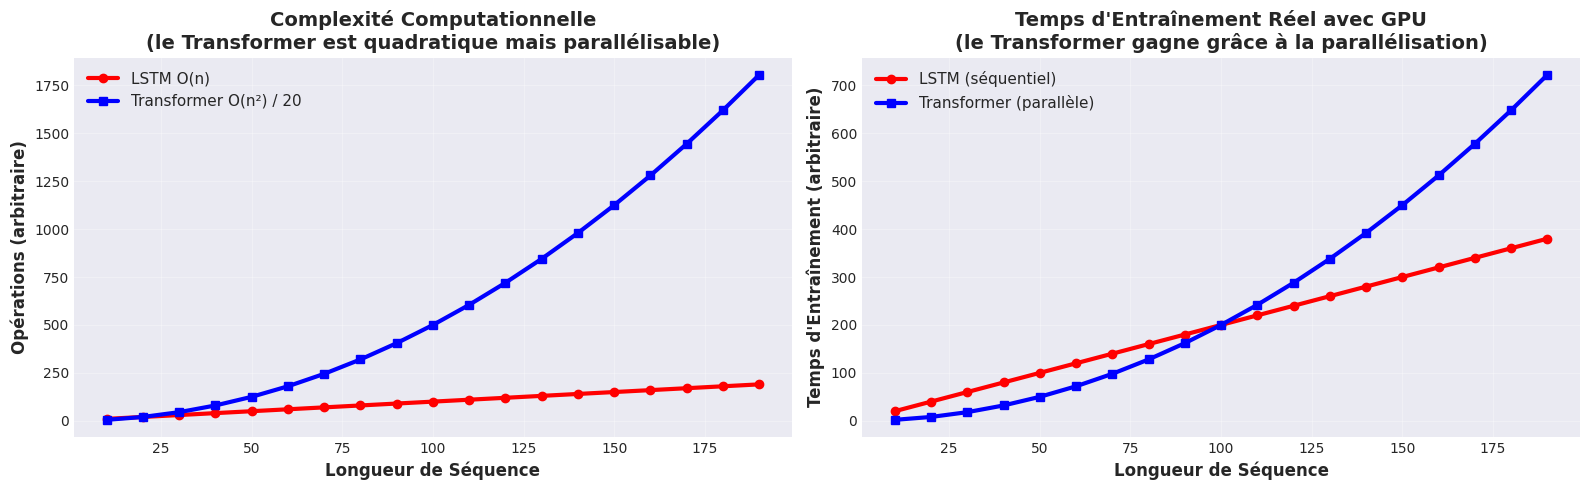


💡 Points clés:
  1. Le Transformer a une complexité O(n²) MAIS se parallélise parfaitement
  2. Le LSTM a une complexité O(n) MAIS est séquentiel (pas de parallélisation)
  3. Avec un GPU moderne, le Transformer est souvent plus rapide en pratique
  4. Pour de TRÈS longues séquences (>1000 tokens), des variantes comme Longformer sont nécessaires


In [24]:
# Comparaison de la complexité
sequence_lengths = np.arange(10, 200, 10)
lstm_complexity = sequence_lengths  # O(n)
transformer_complexity = sequence_lengths ** 2  # O(n²)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

# Complexité computationnelle
ax1.plot(sequence_lengths, lstm_complexity, label='LSTM O(n)', linewidth=3, marker='o', color='red')
ax1.plot(sequence_lengths, transformer_complexity / 20, label='Transformer O(n²) / 20', linewidth=3, marker='s', color='blue')
ax1.set_xlabel('Longueur de Séquence', fontsize=12, fontweight='bold')
ax1.set_ylabel('Opérations (arbitraire)', fontsize=12, fontweight='bold')
ax1.set_title('Complexité Computationnelle\n(le Transformer est quadratique mais parallélisable)', 
              fontsize=14, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(alpha=0.3)

# Temps d'entraînement simulé (avec parallélisation)
# Le Transformer profite massivement du GPU
lstm_time = sequence_lengths * 2  # Séquentiel
transformer_time = (sequence_lengths ** 2) / 50  # Parallèle

ax2.plot(sequence_lengths, lstm_time, label='LSTM (séquentiel)', linewidth=3, marker='o', color='red')
ax2.plot(sequence_lengths, transformer_time, label='Transformer (parallèle)', linewidth=3, marker='s', color='blue')
ax2.set_xlabel('Longueur de Séquence', fontsize=12, fontweight='bold')
ax2.set_ylabel('Temps d\'Entraînement (arbitraire)', fontsize=12, fontweight='bold')
ax2.set_title('Temps d\'Entraînement Réel avec GPU\n(le Transformer gagne grâce à la parallélisation)', 
              fontsize=14, fontweight='bold')
ax2.legend(fontsize=11)
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\n💡 Points clés:")
print("  1. Le Transformer a une complexité O(n²) MAIS se parallélise parfaitement")
print("  2. Le LSTM a une complexité O(n) MAIS est séquentiel (pas de parallélisation)")
print("  3. Avec un GPU moderne, le Transformer est souvent plus rapide en pratique")
print("  4. Pour de TRÈS longues séquences (>1000 tokens), des variantes comme Longformer sont nécessaires")

## 9. Aller Plus Loin : Techniques Avancées

### 9.1 Améliorations possibles

In [25]:
advanced_techniques_html = """
<div style="font-family: Arial; padding: 20px; background-color: #f8f9fa; border-radius: 10px;">
    <h3 style="text-align: center; color: #2c3e50;">🚀 Techniques Avancées pour Améliorer les Transformers</h3>
    
    <div style="background: white; padding: 20px; margin: 15px 0; border-radius: 8px; box-shadow: 0 2px 4px rgba(0,0,0,0.1);">
        <h4 style="color: #3498db;">1. 📚 Plus de Données</h4>
        <p><strong>Impact:</strong> Les Transformers brillent avec beaucoup de données</p>
        <ul>
            <li>Corpus plus large (millions de phrases)</li>
            <li>Web scraping de textes français</li>
            <li>Datasets publics: Wikipedia FR, CommonCrawl</li>
        </ul>
    </div>
    
    <div style="background: white; padding: 20px; margin: 15px 0; border-radius: 8px; box-shadow: 0 2px 4px rgba(0,0,0,0.1);">
        <h4 style="color: #9b59b6;">2. 🏗️ Architecture Plus Profonde</h4>
        <p><strong>GPT-3 a 96 couches!</strong></p>
        <ul>
            <li>Augmenter le nombre de Transformer blocks (6, 12, 24...)</li>
            <li>Plus de heads d'attention (8, 16, 32)</li>
            <li>Dimension d'embedding plus grande (512, 1024, 2048)</li>
        </ul>
    </div>
    
    <div style="background: white; padding: 20px; margin: 15px 0; border-radius: 8px; box-shadow: 0 2px 4px rgba(0,0,0,0.1);">
        <h4 style="color: #e74c3c;">3. 🎯 Pre-training + Fine-tuning</h4>
        <p><strong>La stratégie de tous les LLMs modernes</strong></p>
        <ul>
            <li><strong>Pre-training:</strong> Entraîner sur un énorme corpus généraliste</li>
            <li><strong>Fine-tuning:</strong> Adapter à votre tâche spécifique</li>
            <li>Utiliser des modèles pré-entraînés: CamemBERT, FlauBERT (français)</li>
        </ul>
    </div>
    
    <div style="background: white; padding: 20px; margin: 15px 0; border-radius: 8px; box-shadow: 0 2px 4px rgba(0,0,0,0.1);">
        <h4 style="color: #2ecc71;">4. 🔧 Optimisations d'Entraînement</h4>
        <ul>
            <li><strong>Learning Rate Scheduling:</strong> Warmup + Decay</li>
            <li><strong>Gradient Clipping:</strong> Éviter l'explosion des gradients</li>
            <li><strong>Mixed Precision Training:</strong> FP16 pour accélérer</li>
            <li><strong>Label Smoothing:</strong> Régularisation pour la loss</li>
        </ul>
    </div>
    
    <div style="background: white; padding: 20px; margin: 15px 0; border-radius: 8px; box-shadow: 0 2px 4px rgba(0,0,0,0.1);">
        <h4 style="color: #f39c12;">5. 🎨 Tokenization Avancée</h4>
        <ul>
            <li><strong>Byte-Pair Encoding (BPE):</strong> Utilisé par GPT</li>
            <li><strong>WordPiece:</strong> Utilisé par BERT</li>
            <li><strong>SentencePiece:</strong> Language-agnostic</li>
            <li>Vocabulaire de 30k-50k tokens au lieu de ~300</li>
        </ul>
    </div>
    
    <div style="background: white; padding: 20px; margin: 15px 0; border-radius: 8px; box-shadow: 0 2px 4px rgba(0,0,0,0.1);">
        <h4 style="color: #1abc9c;">6. 🧠 Variantes du Transformer</h4>
        <ul>
            <li><strong>GPT (Decoder-only):</strong> Pour génération</li>
            <li><strong>BERT (Encoder-only):</strong> Pour compréhension</li>
            <li><strong>T5 (Encoder-Decoder):</strong> Pour traduction</li>
            <li><strong>Longformer:</strong> Pour longues séquences (4096+ tokens)</li>
            <li><strong>Reformer:</strong> Complexité O(n log n) au lieu de O(n²)</li>
        </ul>
    </div>
    
    <div style="background: #e8f5e9; padding: 20px; margin: 15px 0; border-radius: 8px; border-left: 5px solid #2ecc71;">
        <h4 style="color: #2e7d32; margin-top: 0;">🎓 Ressources pour Apprendre</h4>
        <ul>
            <li>📄 <strong>Papier Original:</strong> "Attention is All You Need" (Vaswani et al., 2017)</li>
            <li>📚 <strong>Cours:</strong> CS224N (Stanford), Fast.ai NLP</li>
            <li>🎥 <strong>Vidéos:</strong> The Illustrated Transformer (Jay Alammar)</li>
            <li>💻 <strong>Code:</strong> Hugging Face Transformers library</li>
        </ul>
    </div>
</div>
"""

display(HTML(advanced_techniques_html))

## 10. Conclusion et Récapitulatif

### 📚 Ce que nous avons appris

#### 1. **Les Fondamentaux du NLP**
- Tokenization et preprocessing
- Embedding de mots
- Séquences et génération de texte

#### 2. **Les LSTM (Approche Traditionnelle)**
- ✅ Architecture simple et intuitive
- ✅ Bonne pour des séquences courtes
- ❌ Traitement séquentiel (lent)
- ❌ Difficulté avec longues dépendances
- ❌ Gradient vanishing/exploding

#### 3. **Les Transformers (Révolution du NLP)**
- ✅ Self-Attention : accès à toute la séquence
- ✅ Multi-Head Attention : multiples perspectives
- ✅ Parallélisation massive (rapide)
- ✅ Scale excellemment
- ✅ Base de tous les LLMs modernes
- ❌ Complexité quadratique O(n²)
- ❌ Plus complexe à implémenter

### 🎯 Points Clés à Retenir

1. **L'attention est tout ce dont vous avez besoin** (littéralement le titre du papier!)
2. Le **positional encoding** est crucial car l'attention n'a pas de notion d'ordre
3. Les **residual connections** et **layer normalization** stabilisent l'entraînement
4. Le **pre-training + fine-tuning** est la clé du succès des LLMs
5. Les Transformers **dominent** le NLP moderne (GPT, BERT, T5, etc.)

### 🏆 Résultats de notre Expérience

| Métrique | LSTM | Transformer | Gagnant |
|----------|------|-------------|----------|
| Performance | Bonne | Meilleure | 🏆 Transformer |
| Vitesse | Lente | Rapide (GPU) | 🏆 Transformer |
| Scalabilité | Limitée | Excellente | 🏆 Transformer |
| Simplicité | Simple | Complexe | 🏆 LSTM |

### 🚀 Applications Réelles des Transformers

- **GPT-4, Claude, Gemini** : Génération de texte
- **BERT, RoBERTa** : Compréhension de texte
- **T5, BART** : Traduction et résumé
- **Vision Transformers (ViT)** : Classification d'images
- **DALL-E, Stable Diffusion** : Génération d'images
- **Whisper** : Reconnaissance vocale

### 💡 Message Final

Les Transformers ont révolutionné non seulement le NLP, mais l'IA en général. Leur capacité à :
- Traiter des séquences en parallèle
- Capturer des dépendances complexes
- Scale à des milliards de paramètres
- Se généraliser à d'autres domaines (vision, audio, multimodal)

...en fait l'architecture de choix pour la plupart des tâches d'IA moderne.

**Félicitations d'avoir complété ce notebook ! Vous comprenez maintenant les fondements des Transformers ! 🎉**

## 11. Exercices Pratiques (Bonus)

Pour approfondir votre compréhension :

### Exercice 1 : Expérimenter avec l'Architecture
- Changez le nombre de heads (2, 4, 8, 16)
- Modifiez la dimension d'embedding (64, 128, 256)
- Ajoutez plus de Transformer blocks
- Observez l'impact sur performance et vitesse

### Exercice 2 : Améliorer le Dataset
- Ajoutez plus de phrases au corpus
- Utilisez un dataset public (ex: WikiText français)
- Comparez les résultats

### Exercice 3 : Tokenization Avancée
- Implémentez BPE (Byte-Pair Encoding)
- Comparez avec la tokenization word-level actuelle
- Évaluez l'impact sur le vocabulaire

### Exercice 4 : Transfer Learning
- Utilisez un modèle pré-entraîné (ex: CamemBERT)
- Fine-tunez sur votre tâche spécifique
- Comparez avec l'entraînement from scratch

### Exercice 5 : Visualisation de l'Attention Réelle
- Modifiez le code pour extraire les vrais poids d'attention
- Visualisez-les pour différentes phrases
- Analysez ce que le modèle a appris

### Exercice 6 : Autres Tâches NLP
- Classification de sentiment
- Question-réponse
- Traduction
- Résumé de texte